## Get the outputs from each AlexNet layer to the experiment images

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import pymongo as pm
import numpy as np
import h5py
import scipy as sp
import scipy.stats as stats
import os

In [2]:
import tensorflow as tf
from models_alexnet import alexnet
from models_alexnet import alexnet_wrapper


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
from utils import norm_image
from utils import softmax

In [4]:
#setup paths
STIM_PATH = "../data/full_res/"
CKPT_PATH = "../models/checkpoints/alexnet/model.ckpt-115000"

In [5]:
#testing with one training set (sets of 120 images)
with h5py.File(os.path.join(STIM_PATH,"Stimuli_Trn_FullRes_01.mat"),'r') as f:
    stim_set1 = f['stimTrn'][:]

In [6]:
stim_set1.shape

(500, 500, 120)

In [7]:
#make the actual pixel values match the alexnet training images
stim_set1 = stim_set1+.5

#transpose the images so that they make sense
stim_set1 = stim_set1.T
stim_set1.shape

(120, 500, 500)

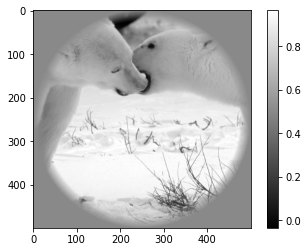

In [8]:
plt.imshow(stim_set1[100,:,:], cmap = "gray")
plt.colorbar()

In [9]:
#add pretend color channels
N = stim_set1[:,:,:,np.newaxis]
stim_set1_rgb = np.tile(N,(1,1,1,3))
stim_set1_rgb.shape

(120, 500, 500, 3)

In [10]:
tf.reset_default_graph()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


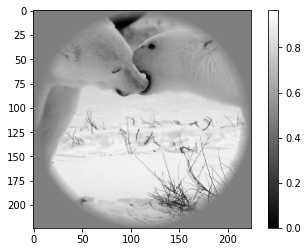

In [11]:
#create image tensor
images = stim_set1_rgb
image_tensor = tf.convert_to_tensor(images, dtype=tf.float32)
#resize for alexnet
resized_images = tf.image.resize_images(image_tensor, (224, 224))

#quick sanity check to make sure we didn't mess anything up resizing
with tf.Session() as sess:
    plt.imshow(sess.run(resized_images[100,:,:,:]),cmap = "gray")
    plt.colorbar()
    plt.show()

In [12]:
model = alexnet(resized_images, train=False)

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
print(model)

In [14]:
# initialize tf Session and restore weighs
sess = tf.Session()
tf_saver = tf.train.Saver()
tf_saver.restore(sess, CKPT_PATH) #restore checkpoint weights

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000


In [15]:
conv1_weights_tensor = tf.get_default_graph().get_tensor_by_name("conv1/weights:0")

In [16]:
print(conv1_weights_tensor)

Tensor("conv1/weights:0", shape=(11, 11, 3, 96), dtype=float32_ref)


In [17]:
#let's sanity check that we've actually restored the weights
sanity_weights = sess.run(conv1_weights_tensor)

In [18]:
print(sanity_weights.shape)

(11, 11, 3, 96)


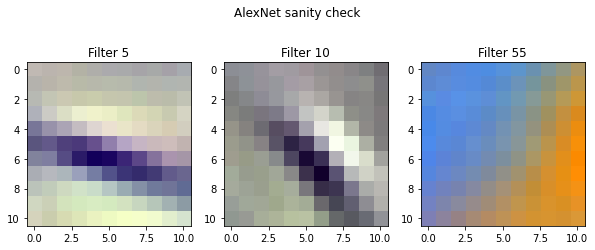

In [19]:
#plot select conv1 filters
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 4), nrows=1, ncols=3)
title = "AlexNet sanity check" 
fig.suptitle(title)

true_filter_1 = norm_image(sanity_weights[:,:,:,5])
ax1.imshow(true_filter_1)
ax1.set_title("Filter 5")

true_filter_5 = norm_image(sanity_weights[:,:,:,10])
ax2.imshow(true_filter_5)
ax2.set_title("Filter 10")

true_filter_10 = norm_image(sanity_weights[:,:,:,55])
ax3.imshow(true_filter_10)
ax3.set_title("Filter 55")

plt.savefig('../figures/alexnet_conv1_filters.png')

(120, 54, 54, 96)


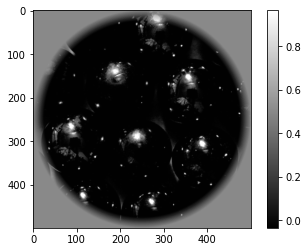

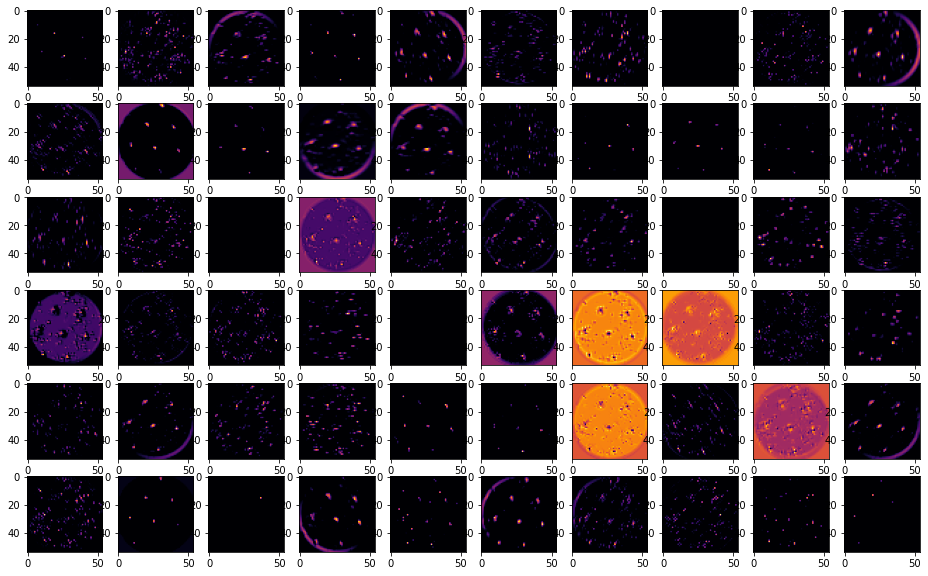

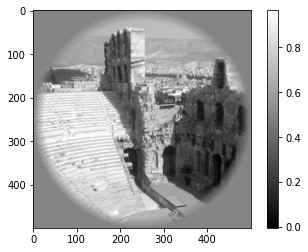

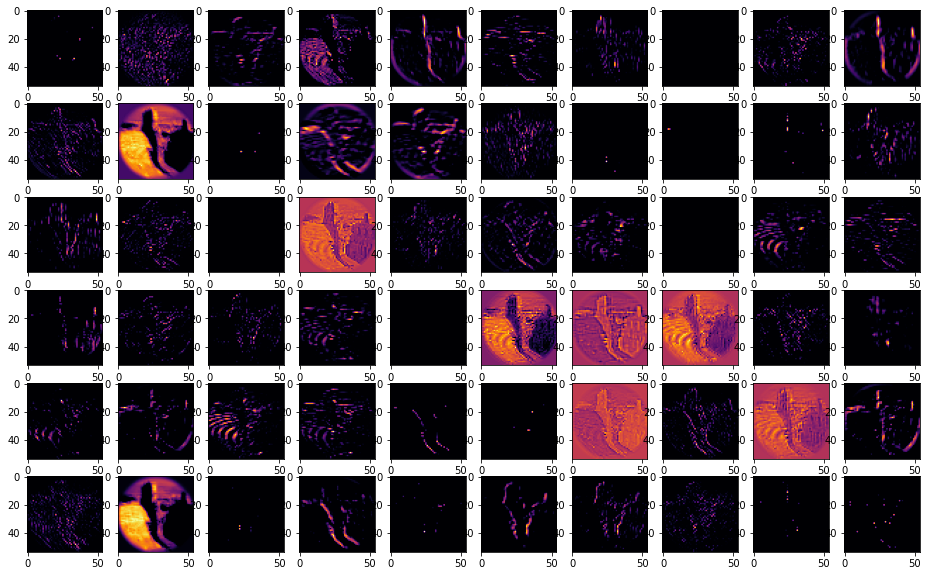

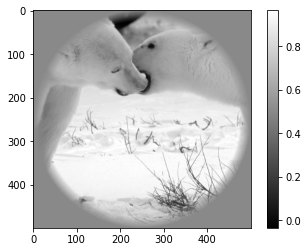

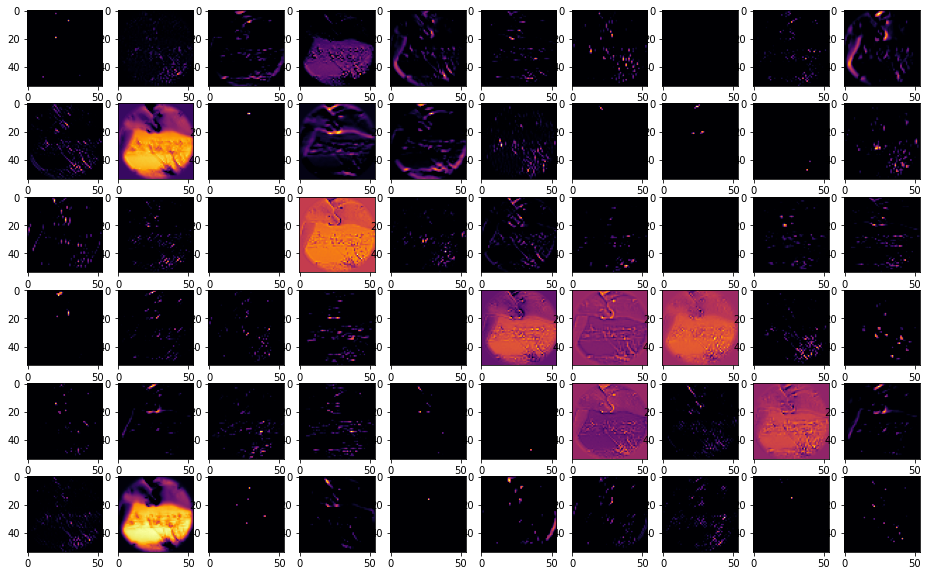

In [20]:
#okay now let's check the conv1 outputs to the images instead of the filters themselves
conv1_outputs = model.layers['conv1']
conv1_outputs = sess.run(conv1_outputs)
print(conv1_outputs.shape)

for image_idx in [1, 10, 100]:
    plt.figure()

    plt.imshow(stim_set1[image_idx,:,:], cmap = "gray")
    plt.colorbar()

    fav_image = conv1_outputs[image_idx,:,:,:]
    fav_image = np.moveaxis(fav_image, -1, 0) #put num of features in first column

    fig = plt.figure(figsize=(16,10))

    for idx in range(60):
        ax = fig.add_subplot(6, 10, idx+1) 
        ax.imshow(fav_image[idx,:,:], cmap="inferno") 


In [21]:
conv3_outputs = model.layers['conv3']

In [22]:
# run whatever tensors we care about
conv3_outputs = sess.run(conv3_outputs)
print(conv3_outputs.shape)

(120, 14, 14, 384)


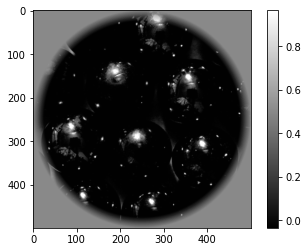

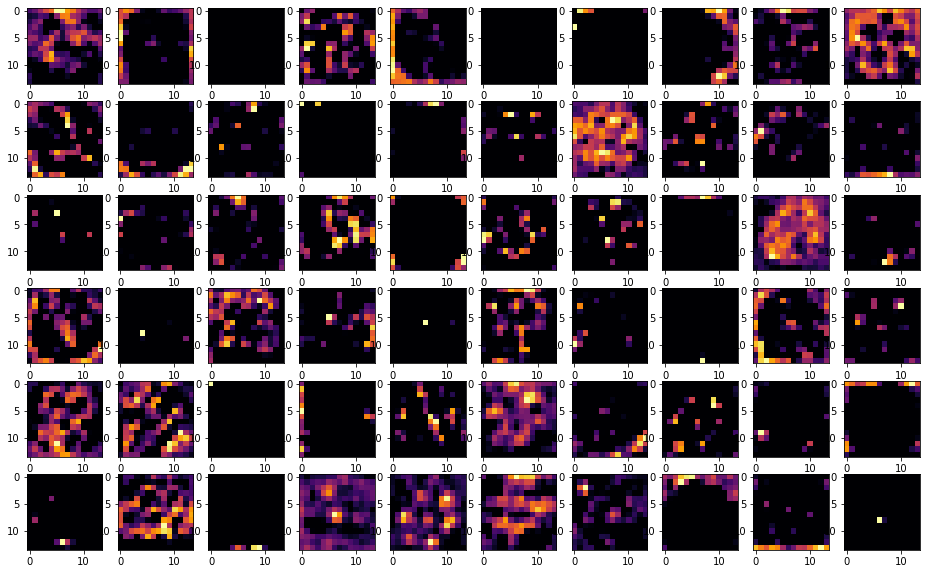

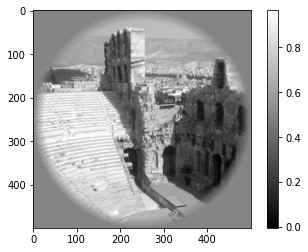

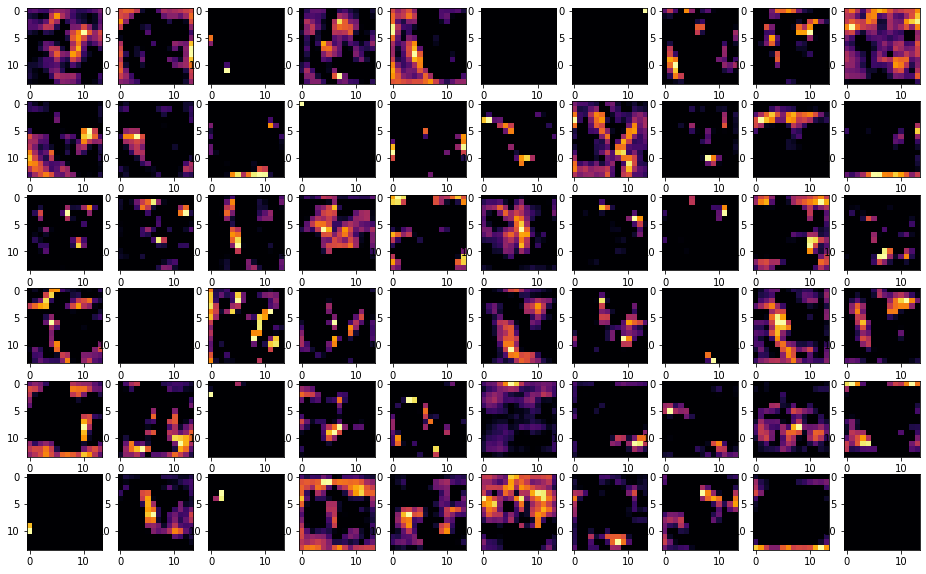

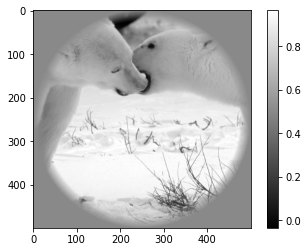

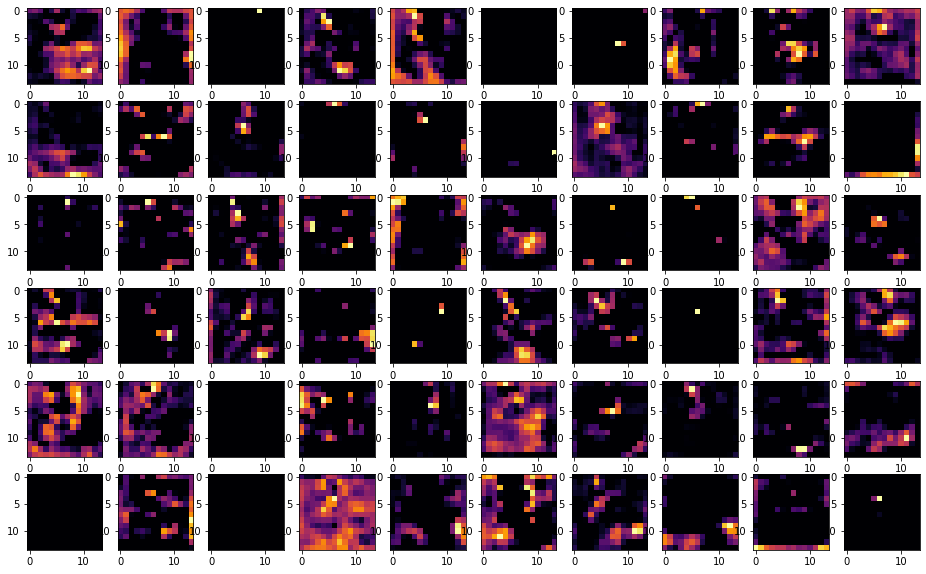

In [23]:
#visualize some features for kicks
for image_idx in [1, 10, 100]:
    plt.figure()

    plt.imshow(stim_set1[image_idx,:,:], cmap = "gray")
    plt.colorbar()

    fav_image = conv3_outputs[image_idx,:,:,:]
    fav_image = np.moveaxis(fav_image, -1, 0) #put num of features in first column

    fig = plt.figure(figsize=(16,10))

    for idx in range(60):
        ax = fig.add_subplot(6, 10, idx+1) 
        ax.imshow(fav_image[idx,:,:], cmap="inferno") 
    #excellent we have logical features

In [24]:
fc8_outputs = model.layers['fc8']
# run the tensors
logits = sess.run(fc8_outputs)
# apply softmax to output
probs = np.zeros((logits.shape))
for col in range(len(logits)): #ugly but works
    probs[col,:] = softmax(logits[col,:])
winning_class = (np.argmax(probs,1)) #top 1

In [25]:
print(winning_class.shape)

(120,)


In [26]:
print(winning_class[1])
print(winning_class[10])
print(winning_class[100])

971
554
971


In [28]:
#the winning class is mostly "bubbles"... should I crop closer?

In [29]:
num_train_batch = 15 #15th batch only has 20 images
stim_set = []

In [30]:
layer_keys = ['conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'fc6', 'fc7']
total_outputs = {}

In [31]:
# now let's do this for all the training images, not just the first batch, and for all layers

for idx in range(0,num_train_batch):
    if idx < 9:
        base_str = ['Stimuli_Trn_FullRes_0','.mat']
    else:
        base_str = ['Stimuli_Trn_FullRes_','.mat']
            
    num = str(idx+1)
    
    fullfile = num.join(base_str)
    
    with h5py.File(os.path.join(STIM_PATH,fullfile),'r') as f:
        stim_set = f['stimTrn'][:]
        
    #make the actual pixel values match the alexnet training images
    stim_set = stim_set+.5

    #transpose the images so that they make sense
    stim_set = stim_set.T

    #add pretend color channels
    N = stim_set[:,:,:,np.newaxis]
    stim_set_rgb = np.tile(N,(1,1,1,3))
    
    #create image tensor
    batch_images = stim_set_rgb
    batch_image_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
    #resize for alexnet
    batch_resized_images = tf.image.resize_images(batch_image_tensor, (224, 224))
    
    # initialize model
    batch_convnet = alexnet(batch_resized_images)
    
    with tf.Session() as sess:
        tf_saver = tf.train.Saver()
        tf_saver.restore(sess, CKPT_PATH) #restore checkpoint weights

        for layer in layer_keys:
            print(layer)
            # define output tensors of interest
            batch_outputs = batch_convnet.layers[layer]

            # run whatever tensors we care about
            batch_outputs = sess.run(batch_outputs)

            if idx == 0:
                total_outputs[layer] = batch_outputs
            else:
                total_outputs[layer] = np.concatenate((total_outputs[layer],batch_outputs),axis=0)

            print(total_outputs[layer].shape)
        

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000
conv1
(120, 54, 54, 96)
conv2
(120, 27, 27, 256)
conv3
(120, 14, 14, 384)
conv4
(120, 14, 14, 384)
conv5
(120, 14, 14, 256)
fc6
(120, 4096)
fc7
(120, 4096)
INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000
conv1
(240, 54, 54, 96)
conv2
(240, 27, 27, 256)
conv3
(240, 14, 14, 384)
conv4
(240, 14, 14, 384)
conv5
(240, 14, 14, 256)
fc6
(240, 4096)
fc7
(240, 4096)
INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000
conv1
(360, 54, 54, 96)
conv2
(360, 27, 27, 256)
conv3
(360, 14, 14, 384)
conv4
(360, 14, 14, 384)
conv5
(360, 14, 14, 256)
fc6
(360, 4096)
fc7
(360, 4096)
INFO:tensorflow:Restoring parameters from ../models/checkpoints/alexnet/model.ckpt-115000
conv1
(480, 54, 54, 96)
conv2
(480, 27, 27, 256)
conv3
(4

In [32]:
total_outputs['conv1'].shape

(1750, 54, 54, 96)

In [33]:
for k, v in total_outputs.items():
    print(k)

conv1
conv2
conv3
conv4
conv5
fc6
fc7


In [34]:
#let's save the features as h5py to use for fitting in another notebook
h5f = h5py.File('../models/features/alexnet_train_features.h5', 'w')
for k, v in total_outputs.items():
    h5f.create_dataset(str(k), data=v)

In [35]:
h5f.close()

In [ ]:
# and now for the validation images
total_val_outputs = {}

with h5py.File(os.path.join(STIM_PATH,"Stimuli_Val_FullRes.mat"),'r') as f:
        stim_set = f['stimVal'][:]
        
#make the actual pixel values match the alexnet training images
stim_set = stim_set+.5

#transpose the images so that they make sense
stim_set = stim_set.T

#add pretend color channels
N = stim_set[:,:,:,np.newaxis]
stim_set_rgb = np.tile(N,(1,1,1,3))

#create image tensor
val_images = stim_set_rgb
val_image_tensor = tf.convert_to_tensor(val_images, dtype=tf.float32)
#resize for alexnet
val_resized_images = tf.image.resize_images(val_image_tensor, (224, 224))

# initialize model
val_convnet = alexnet(val_resized_images)

with tf.Session() as sess:
    tf_saver = tf.train.Saver()
    tf_saver.restore(sess, CKPT_PATH) #restore checkpoint weights

    for layer in layer_keys:
        print(layer)

        # define output tensors of interest
        val_outputs = val_convnet.layers[layer]

        # run whatever tensors we care about
        total_val_outputs[layer] = sess.run(val_outputs)

        print(total_val_outputs[layer].shape)

In [ ]:
#let's save the features as h5py to use for fitting in another notebook
valh5f = h5py.File('../models/features/alexnet_val_features.h5', 'w')
for k, v in total_val_outputs.items():
    valh5f.create_dataset(str(k), data=v)

In [ ]:
valh5f.close()